Credit to Frederik of Cambdridge Spark

In [ ]:

forecast_years=10
gp_lags=5
indicators={"GDP": "NY.GDP.MKTP.CD" , "Population": "SP.POP.TOTL", "Inflation":"FP.CPI.TOTL.ZG"}
n_indicators=len(indicators)

In [2]:
target_variable="GDP"
countries=['au','ca','de','es','fr','gb','jp','us']
n_countries=len(countries)

In [3]:
s_year=1981
e_year=2021


In [4]:
import requests
import pandas as pd

In [5]:
template_url="http://api.worldbank.org/v2/countries/{0}/indicators/{1}?date={2}:{3}&format=json&per_page=999"

In [6]:
country_str=';'.join(countries)
raw_data=pd.DataFrame()
for label, indicator in indicators.items():
    url=template_url.format(country_str,indicator,s_year,e_year)
    json_data=requests.get(url)
    json_data=json_data.json()
    json_data=json_data[1]
    for data_point in json_data:
        country=data_point['country']['id']
        item=country+'__'+ label
        year=data_point['date']
        value=data_point['value']
        new_row=pd.DataFrame([[item,year,value]],columns=['item','year','value'])
        raw_data=raw_data.append(new_row)
        


In [7]:
raw_data=raw_data.pivot('year','item','value')
print('\n',raw_data.iloc[:10,:5],'\n')


 item       AU__GDP  AU__Inflation  AU__Population       CA__GDP  CA__Inflation
year                                                                          
1981  1.769534e+11       9.487666      14927000.0  3.062149e+11      12.471612
1982  1.941046e+11      11.351820      15178000.0  3.135065e+11      10.768972
1983  1.773336e+11      10.038911      15369000.0  3.405477e+11       5.863588
1984  1.935936e+11       3.960396      15544000.0  3.553726e+11       4.304778
1985  1.805738e+11       6.734694      15758000.0  3.647565e+11       3.962031
1986  1.823685e+11       9.050351      16018400.0  3.774379e+11       4.194786
1987  1.894005e+11       8.533022      16263900.0  4.313167e+11       4.356109
1988  2.360659e+11       7.215940      16532200.0  5.073544e+11       4.028234
1989  2.997679e+11       7.533903      16814400.0  5.650557e+11       4.983622
1990  3.113267e+11       7.333022      17065100.0  5.939296e+11       4.780477 



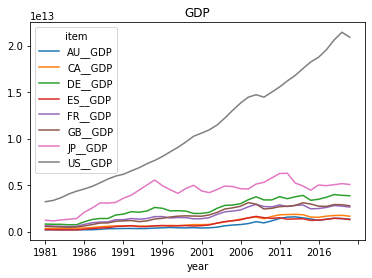

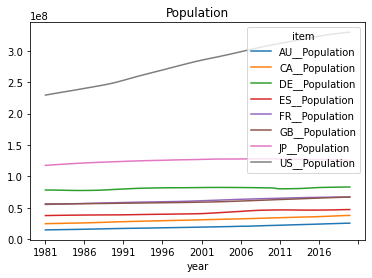

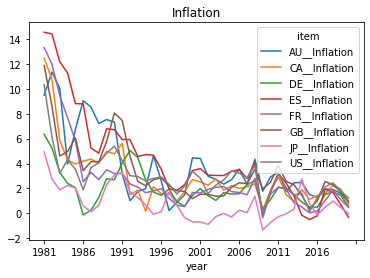

In [8]:
import matplotlib.pyplot as plt
for lab in indicators.keys():
    indicator=raw_data[[x for x in raw_data.columns 
                        if x.split("_")[-1]==lab]]
    indicator.plot(title=lab)
    plt.show()

In [9]:
import numpy as np
data=np.log(raw_data).diff().iloc[1:,:]
data.fillna(0,inplace=True)
data=data-data.mean()
data.index=pd.to_datetime(data.index, format='%Y')
target=data[[x for x in data.columns
            if x.split("_")[-1]== target_variable]]

In [10]:
errors=target.iloc[-forecast_years:] - target.shift().iloc[-forecast_years:]
rmse=errors.pow(2).sum().sum()/(forecast_years*n_countries)**.5
print('\n'+ '_'*18)
print("\t| Error:", np.round(rmse,4),'|')
print('\t'+'_'*18+'\n')


__________________
	| Error: 0.075 |
	__________________



In [11]:
from statsmodels.tsa.api import VAR
sse=0

for t in range(forecast_years):
    model=VAR(target.iloc[t:-forecast_years+t], freq='AS')
    results=model.fit(maxlags=1)
    
    actual_values=target.values[-forecast_years+t+1]
    forecasts=results.forecast(target.values[:-forecast_years+t],1)
    forecasts=forecasts[0,:n_countries]
sse+= ((actual_values- forecasts)**2).sum()
rmse= (sse/(forecast_years* n_countries))**.5

print('\n\t'+'_'*18)
print("\t| Error: :", np.round(rmse,4),'|')
print('\t'+'-'*18+'\n')



	__________________
	| Error: : 0.0207 |
	------------------



In [12]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

In [13]:
gpr=GaussianProcessRegressor(kernel=RBF(0.1), alpha=0.1)
ndata=target.shape[0]-forecast_years-gp_lags
sse=0

In [14]:
for t in range(forecast_years):
    y=np.zeros((ndata, n_countries))
    x=np.zeros((ndata, gp_lags*n_countries*n_indicators))
    for i in range(ndata):
        y[i]=target.iloc[t+i+1]
        x[i]=data.iloc[t+i+2:t+i+2+gp_lags].values.flatten()
    gpr.fit(x,y)
    

In [15]:
x_test= np.expand_dims(data.iloc[t+1:t+1+gp_lags].values.flatten(),0)
forecast=gpr.predict(x_test)

In [16]:
sse+= ((target.iloc[t].values-forecast)**2).sum()
rmse=(sse/(forecast_years*n_countries))**.5
print('\n\t'+'-'*18)
print("\t| Error: ", np.round(rmse,4), '|')
print('\t'+'-'*18+'\n')


	------------------
	| Error:  0.0124 |
	------------------

